# XGBoost Pipeline Test - Setup and Data Preparation

This notebook handles the initial setup and synthetic data generation for the XGBoost 3-step pipeline test.

**Pipeline Steps:**
1. XGBoost Training
2. XGBoost Model Evaluation  
3. Model Calibration

**This notebook covers:**
- Environment setup and imports
- Synthetic dataset generation
- Data exploration and visualization
- Save datasets for use in other notebooks

## 1. Environment Setup and Imports

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add cursus to path
sys.path.append(str(Path.cwd().parent.parent.parent / 'src'))

# Import Cursus components
try:
    from cursus.validation.runtime.jupyter.notebook_interface import NotebookInterface
    from cursus.validation.runtime.core.data_flow_manager import DataFlowManager
    from cursus.steps.registry.step_names import STEP_NAMES
    print("✓ Successfully imported Cursus components")
    cursus_available = True
except ImportError as e:
    print(f"⚠ Import error: {e}")
    print("Continuing with mock implementations for testing...")
    cursus_available = False

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print(f"Setup completed at {datetime.now()}")
print(f"Cursus components available: {cursus_available}")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/tianpeixie/Library/Application Support/sagemaker/config.yaml


2025-08-26 08:22:05,136 - pipeline_registry.builder_registry - INFO - Registered builder: BatchTransform -> BatchTransformStepBuilder
INFO:pipeline_registry.builder_registry:Registered builder: BatchTransform -> BatchTransformStepBuilder
2025-08-26 08:22:05,137 - pipeline_registry.builder_registry - INFO - Registered builder: CurrencyConversion -> CurrencyConversionStepBuilder
INFO:pipeline_registry.builder_registry:Registered builder: CurrencyConversion -> CurrencyConversionStepBuilder
2025-08-26 08:22:05,138 - pipeline_registry.builder_registry - INFO - Registered builder: DummyTraining -> DummyTrainingStepBuilder
INFO:pipeline_registry.builder_registry:Registered builder: DummyTraining -> DummyTrainingStepBuilder
2025-08-26 08:22:05,140 - pipeline_registry.builder_registry - INFO - Registered builder: ModelCalibration -> ModelCalibrationStepBuilder
INFO:pipeline_registry.builder_registry:Registered builder: ModelCalibration -> ModelCalibrationStepBuilder
2025-08-26 08:22:05,141 - pi

✓ Successfully imported Cursus components
Setup completed at 2025-08-26 08:22:05.349731
Cursus components available: True


## 2. Directory Structure Setup

In [2]:
# Define directory structure
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / 'data'
CONFIG_DIR = BASE_DIR / 'configs'
OUTPUTS_DIR = BASE_DIR / 'outputs'
WORKSPACE_DIR = OUTPUTS_DIR / 'workspace'
LOGS_DIR = OUTPUTS_DIR / 'logs'
RESULTS_DIR = OUTPUTS_DIR / 'results'

# Create directories
directories = [DATA_DIR, CONFIG_DIR, OUTPUTS_DIR, WORKSPACE_DIR, LOGS_DIR, RESULTS_DIR]
for directory in directories:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✓ Created directory: {directory}")

print("\nDirectory structure created successfully!")

✓ Created directory: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/data
✓ Created directory: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/configs
✓ Created directory: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/outputs
✓ Created directory: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/outputs/workspace
✓ Created directory: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/outputs/logs
✓ Created directory: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/outputs/results

Directory structure created successfully!


## 3. Synthetic Dataset Generation

In [3]:
def generate_synthetic_dataset(n_samples=1000, n_features=10, random_state=42, dataset_name="dataset"):
    """
    Generate synthetic dataset for XGBoost training and evaluation.
    
    Args:
        n_samples: Number of samples to generate
        n_features: Number of features
        random_state: Random seed for reproducibility
        dataset_name: Name for logging purposes
    
    Returns:
        tuple: (X_df, y_df) - Features and target DataFrames
    """
    print(f"Generating {dataset_name} with {n_samples} samples and {n_features} features...")
    
    np.random.seed(random_state)
    
    # Generate features with different distributions
    X = np.random.randn(n_samples, n_features)
    
    # Add some correlated features
    if n_features >= 3:
        X[:, 2] = 0.5 * X[:, 0] + 0.3 * X[:, 1] + 0.2 * np.random.randn(n_samples)
    
    # Generate target with non-linear relationships
    y_continuous = (
        2.0 * X[:, 0] + 
        1.5 * X[:, 1] - 
        0.8 * X[:, 2] + 
        0.5 * X[:, 0] * X[:, 1] +  # Interaction term
        0.3 * np.sin(X[:, 0]) +    # Non-linear term
        np.random.normal(0, 0.1, n_samples)  # Noise
    )
    
    # Convert to binary classification (balanced)
    y_binary = (y_continuous > np.median(y_continuous)).astype(int)
    
    # Create feature names
    feature_names = [f'feature_{i}' for i in range(n_features)]
    
    # Create DataFrames
    X_df = pd.DataFrame(X, columns=feature_names)
    y_df = pd.DataFrame({'target': y_binary})
    
    print(f"✓ Generated {dataset_name}: X shape {X_df.shape}, y distribution: {np.bincount(y_binary)}")
    
    return X_df, y_df

# Generate training and evaluation datasets
print("=" * 50)
print("GENERATING SYNTHETIC DATASETS")
print("=" * 50)

X_train, y_train = generate_synthetic_dataset(
    n_samples=800, 
    n_features=10, 
    random_state=42, 
    dataset_name="training dataset"
)

X_eval, y_eval = generate_synthetic_dataset(
    n_samples=200, 
    n_features=10, 
    random_state=123, 
    dataset_name="evaluation dataset"
)

print("\nDataset generation completed!")

GENERATING SYNTHETIC DATASETS
Generating training dataset with 800 samples and 10 features...
✓ Generated training dataset: X shape (800, 10), y distribution: [400 400]
Generating evaluation dataset with 200 samples and 10 features...
✓ Generated evaluation dataset: X shape (200, 10), y distribution: [100 100]

Dataset generation completed!


## 4. Data Exploration and Visualization

In [4]:
# Combine datasets for exploration
train_data = pd.concat([X_train, y_train], axis=1)
eval_data = pd.concat([X_eval, y_eval], axis=1)

print("TRAINING DATA SUMMARY")
print("=" * 30)
print(f"Shape: {train_data.shape}")
print(f"Target distribution: {train_data['target'].value_counts().to_dict()}")
print("\nFirst few rows:")
display(train_data.head())

print("\nEVALUATION DATA SUMMARY")
print("=" * 30)
print(f"Shape: {eval_data.shape}")
print(f"Target distribution: {eval_data['target'].value_counts().to_dict()}")

TRAINING DATA SUMMARY
Shape: (800, 11)
Target distribution: {1: 400, 0: 400}

First few rows:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,0.496714,-0.138264,0.200273,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,1
1,-0.463418,-0.465730,-0.472158,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,0
2,1.465649,-0.225776,0.630617,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,1
3,-0.601707,1.852278,0.397776,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861,1
4,0.738467,0.171368,0.676215,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040,1



EVALUATION DATA SUMMARY
Shape: (200, 11)
Target distribution: {0: 100, 1: 100}


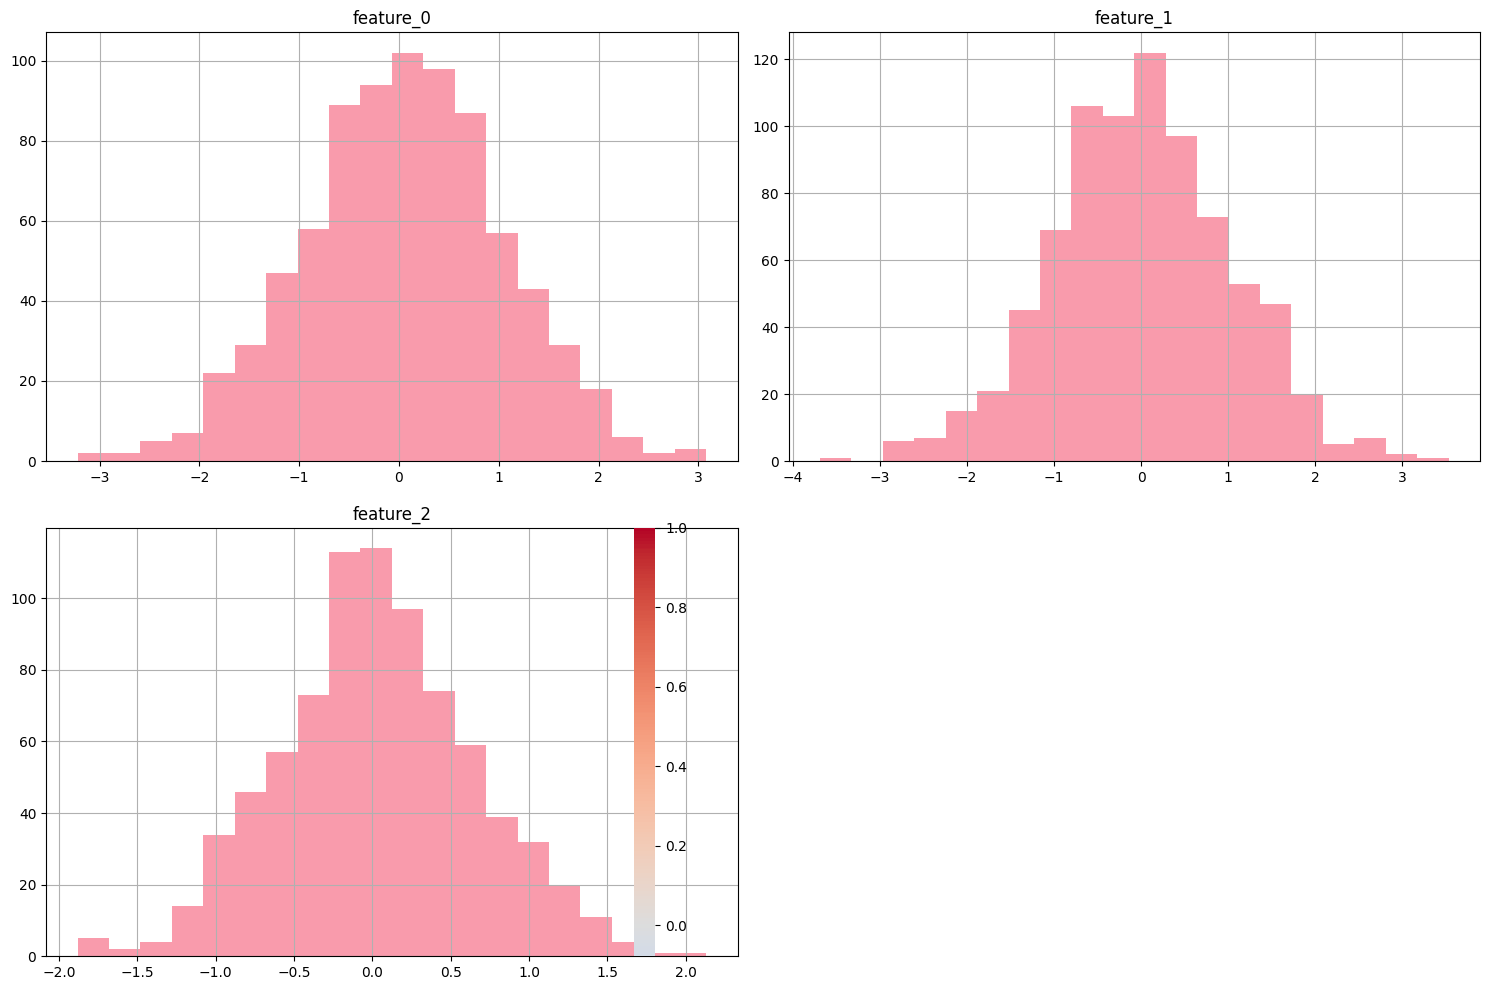

Data exploration visualizations completed!


In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Synthetic Dataset Analysis', fontsize=16, fontweight='bold')

# 1. Feature distributions
ax1 = axes[0, 0]
train_data[['feature_0', 'feature_1', 'feature_2']].hist(ax=ax1, bins=20, alpha=0.7)
ax1.set_title('Feature Distributions (Training)')
ax1.legend(['Feature 0', 'Feature 1', 'Feature 2'])

# 2. Target distribution
ax2 = axes[0, 1]
train_target_counts = train_data['target'].value_counts()
ax2.bar(train_target_counts.index, train_target_counts.values, color=['lightcoral', 'lightblue'])
ax2.set_title('Target Distribution (Training)')
ax2.set_xlabel('Target Class')
ax2.set_ylabel('Count')
for i, v in enumerate(train_target_counts.values):
    ax2.text(i, v + 5, str(v), ha='center', va='bottom')

# 3. Feature correlation heatmap
ax3 = axes[1, 0]
correlation_matrix = train_data.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=ax3, fmt='.2f')
ax3.set_title('Feature Correlation Matrix')

# 4. Feature vs Target relationship
ax4 = axes[1, 1]
for target_class in [0, 1]:
    subset = train_data[train_data['target'] == target_class]
    ax4.scatter(subset['feature_0'], subset['feature_1'], 
               alpha=0.6, label=f'Class {target_class}')
ax4.set_xlabel('Feature 0')
ax4.set_ylabel('Feature 1')
ax4.set_title('Feature 0 vs Feature 1 by Target Class')
ax4.legend()

plt.tight_layout()
plt.show()

print("Data exploration visualizations completed!")

## 5. Save Datasets

In [6]:
# Save datasets to CSV files
train_data_path = DATA_DIR / 'train_data.csv'
eval_data_path = DATA_DIR / 'eval_data.csv'

train_data.to_csv(train_data_path, index=False)
eval_data.to_csv(eval_data_path, index=False)

print(f"✓ Training data saved: {train_data_path}")
print(f"✓ Evaluation data saved: {eval_data_path}")

# Save dataset metadata
metadata = {
    'creation_timestamp': datetime.now().isoformat(),
    'training_data': {
        'path': str(train_data_path),
        'shape': train_data.shape,
        'target_distribution': train_data['target'].value_counts().to_dict(),
        'features': list(X_train.columns)
    },
    'evaluation_data': {
        'path': str(eval_data_path),
        'shape': eval_data.shape,
        'target_distribution': eval_data['target'].value_counts().to_dict(),
        'features': list(X_eval.columns)
    },
    'generation_parameters': {
        'train_samples': 800,
        'eval_samples': 200,
        'n_features': 10,
        'train_random_state': 42,
        'eval_random_state': 123
    }
}

metadata_path = DATA_DIR / 'dataset_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Dataset metadata saved: {metadata_path}")

print("\n" + "=" * 50)
print("SETUP AND DATA PREPARATION COMPLETED")
print("=" * 50)
print(f"Training data: {train_data.shape[0]} samples, {train_data.shape[1]-1} features")
print(f"Evaluation data: {eval_data.shape[0]} samples, {eval_data.shape[1]-1} features")
print(f"Data saved to: {DATA_DIR}")
print("\nReady for pipeline configuration and testing!")

✓ Training data saved: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/data/train_data.csv
✓ Evaluation data saved: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/data/eval_data.csv
✓ Dataset metadata saved: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/data/dataset_metadata.json

SETUP AND DATA PREPARATION COMPLETED
Training data: 800 samples, 10 features
Evaluation data: 200 samples, 10 features
Data saved to: /Users/tianpeixie/github_workspace/cursus/test/integration/runtime/data

Ready for pipeline configuration and testing!
